In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import cv2
import os
import matplotlib.pyplot as plt

In [12]:
def load_data(data_image_path, data_label_path):
    images = []
    labels = []
    
    for file in os.listdir(data_image_path):
        file_p = os.path.join(data_image_path, file)
        image = cv2.imread(file_p)
        image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
        images.append(image)
    
    for file in os.listdir(data_label_path):
        file_p = os.path.join(data_label_path, file)
        with open(file_p, "r") as f:
            label = int(f.read(1))
        labels.append(label)
    
    images = np.array(images) / 255.0
    labels = np.array(labels)
    
    return images, labels

nontargetted fgsm

In [13]:
def generate_image_adversary_nontargeted(model, image, label, eps=2 / 255.0):
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        pred = model(image, training=False)
        loss = SparseCategoricalCrossentropy()(tf.convert_to_tensor([label]), pred)
    
    gradient = tape.gradient(loss, image)
    signedGrad = tf.sign(gradient)
    adversary = image + (signedGrad * eps)
    adversary = tf.clip_by_value(adversary, 0, 1)
    
    return adversary.numpy().squeeze()

targetted fgsm

In [14]:
def generate_image_adversary_targeted(model, image, target_label, eps=2 / 255.0):
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        pred = model(image, training=False)
        target_one_hot = tf.one_hot(target_label, depth=pred.shape[-1])
        loss = tf.keras.losses.MSE(target_one_hot, pred)
    
    gradient = tape.gradient(loss, image)
    signedGrad = tf.sign(gradient)
    adversary = image + (signedGrad * eps)
    adversary = tf.clip_by_value(adversary, 0, 1)
    
    return adversary.numpy().squeeze()

In [15]:
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [16]:
def adversarial_training(model, x_train, y_train, eps=2 / 255.0, epochs=10, batch_size=128):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    loss_fn = SparseCategoricalCrossentropy()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            with tf.GradientTape() as tape:
                adv_x_batch = np.array([generate_image_adversary_nontargeted(model, x, y, eps) for x, y in zip(x_batch, y_batch)])
                adv_x_batch = tf.convert_to_tensor(adv_x_batch)
                with tf.GradientTape() as inner_tape:
                    predictions = model(adv_x_batch, training=True)
                    loss = loss_fn(y_batch, predictions)
                gradients = inner_tape.gradient(loss, model.trainable_variables)
            
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
def test_and_visualize(model, x_test, y_test, eps=2 / 255.0, target_class=None):
    for i in np.random.choice(len(x_test), size=10):
        image = x_test[i]
        label = y_test[i]
        
        if target_class is not None:
            adversary = generate_image_adversary_targeted(model, image, target_class, eps)
        else:
            adversary = generate_image_adversary_nontargeted(model, image, label, eps)
        
        pred = model.predict(np.expand_dims(adversary, axis=0))
        image_pred = np.argmax(np.array([label]))
        adversary_pred = np.argmax(pred[0])
        confidence = pred[0].max() * 100  # Convert probability to percentage
        
        color = 'green'
        if target_class is not None and adversary_pred == target_class:
            color = 'red'
        
        adversary = adversary * 255
        adversary = np.clip(adversary, 0, 255).astype("uint8")
        image = image * 255
        image = np.clip(image, 0, 255).astype("uint8")
        
        image = cv2.resize(image, (384, 384))
        adversary = cv2.resize(adversary, (384, 384))
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[0].set_title(f'Original: {image_pred}')
        ax[0].axis('off')
        
        ax[1].imshow(cv2.cvtColor(adversary, cv2.COLOR_BGR2RGB))
        ax[1].set_title(f'Adversarial: {adversary_pred} ({confidence:.2f}%)')
        ax[1].axis('off')
        
        plt.show()

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


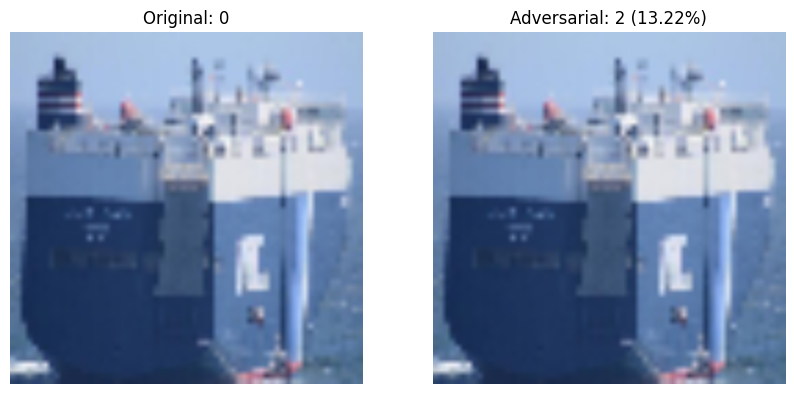

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


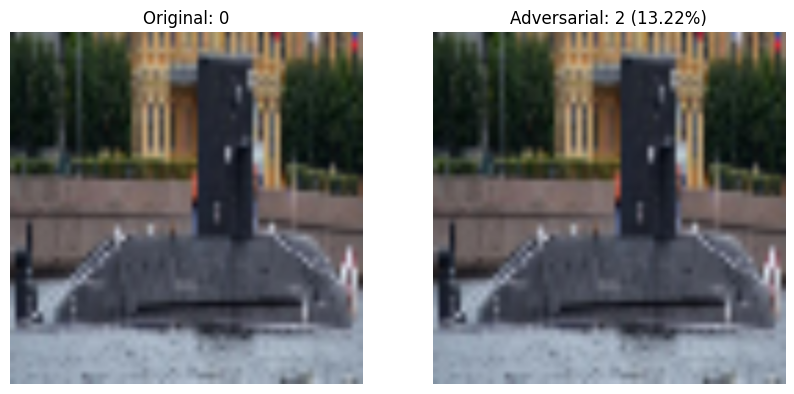

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


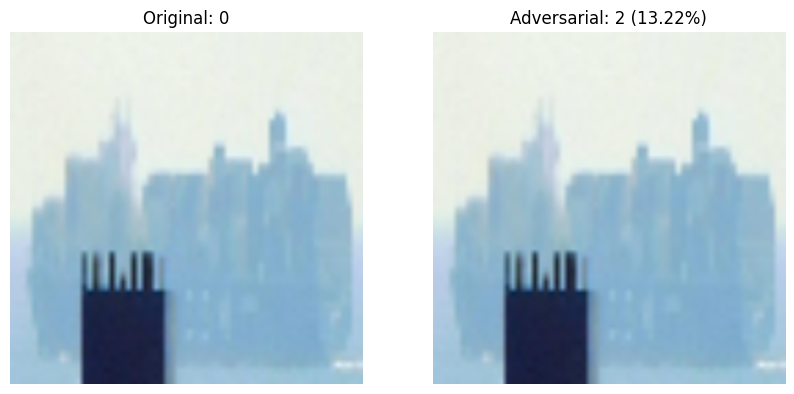

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


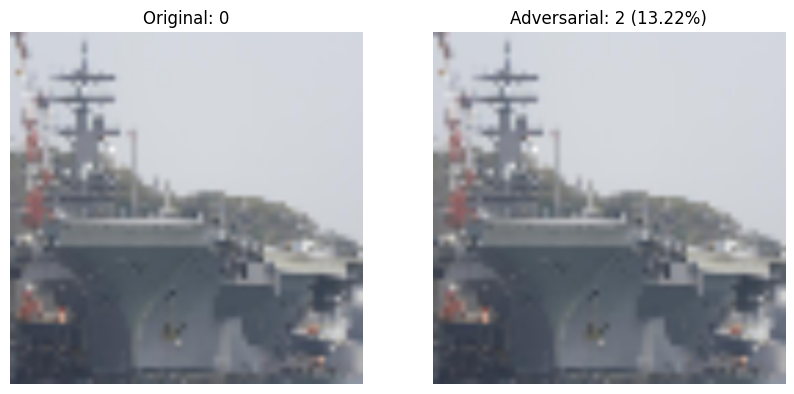

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


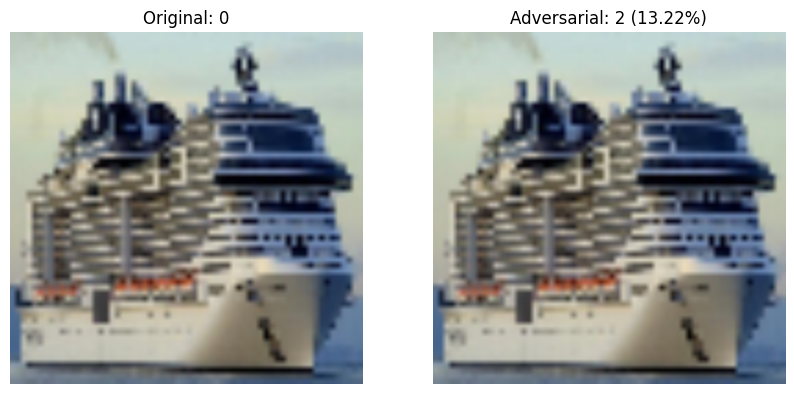

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


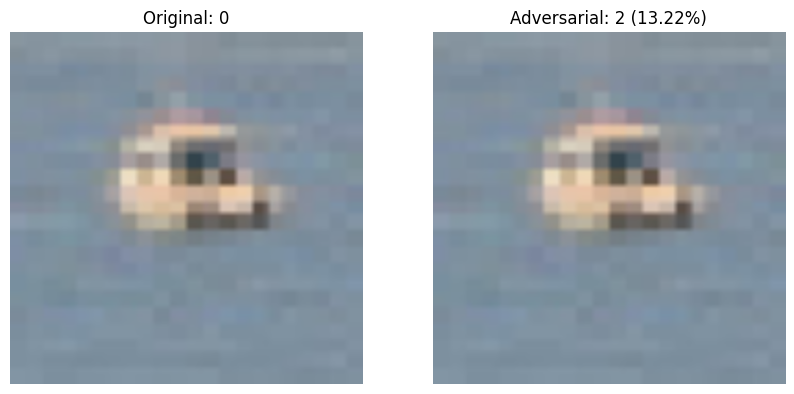

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


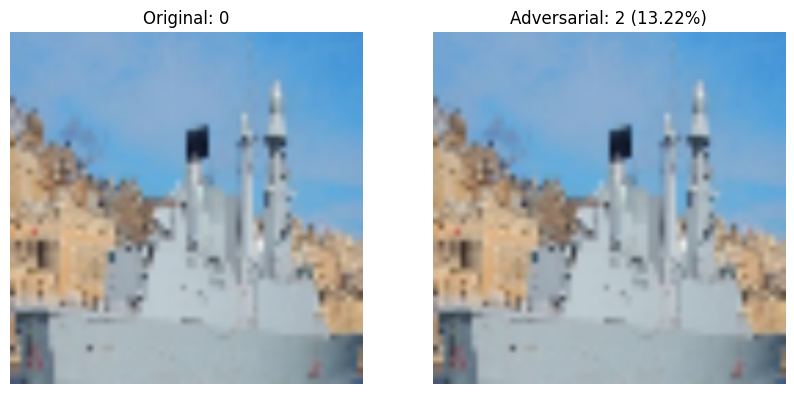

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


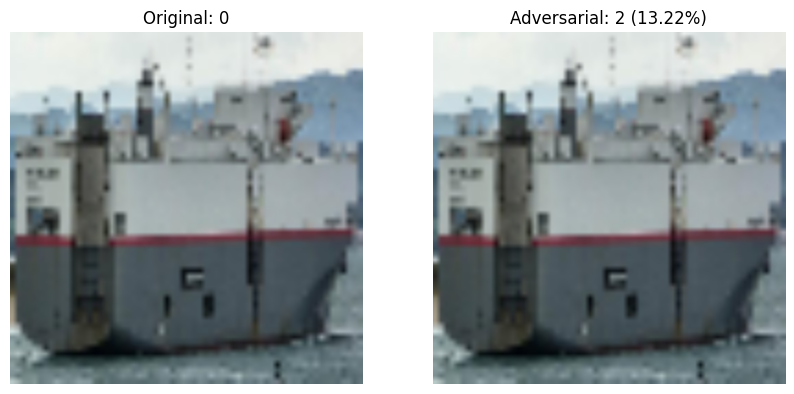

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


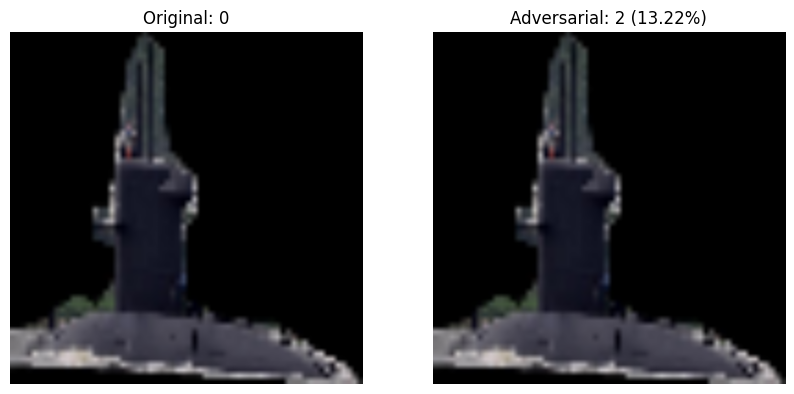

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


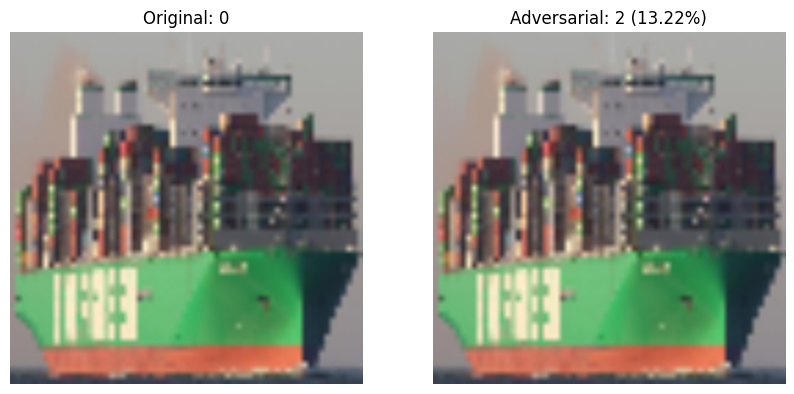

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


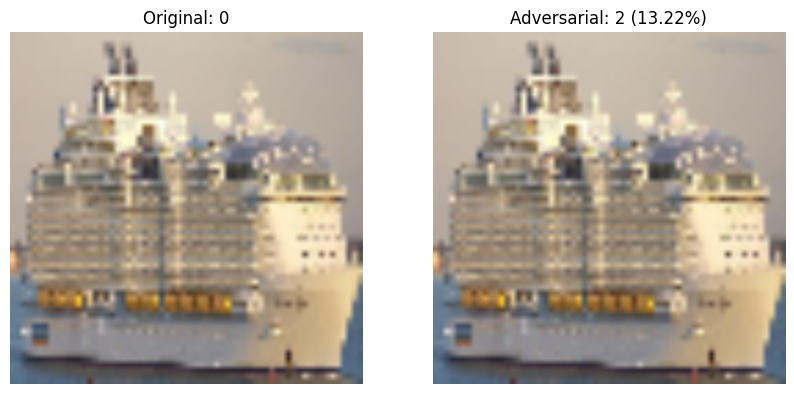

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


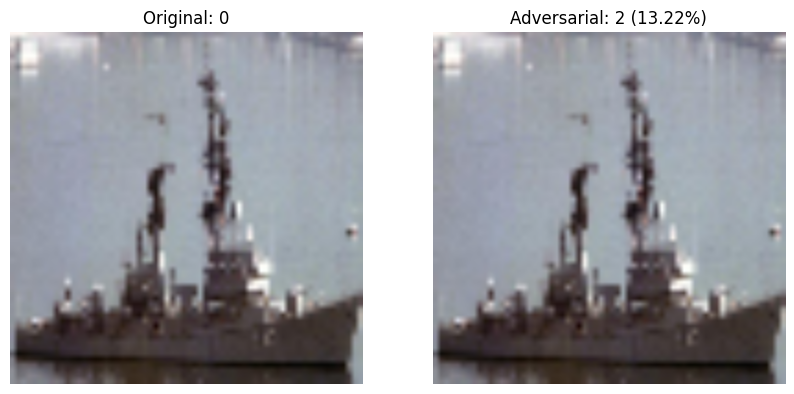

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


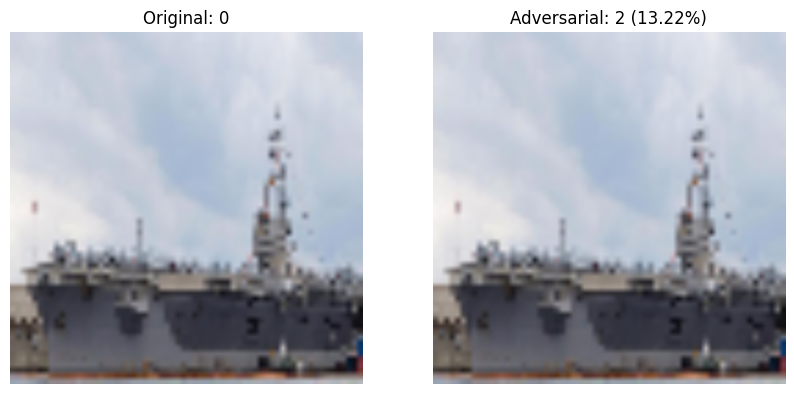

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


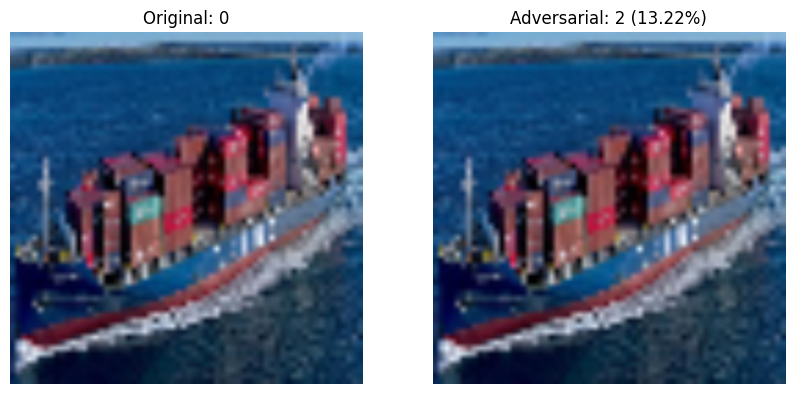

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


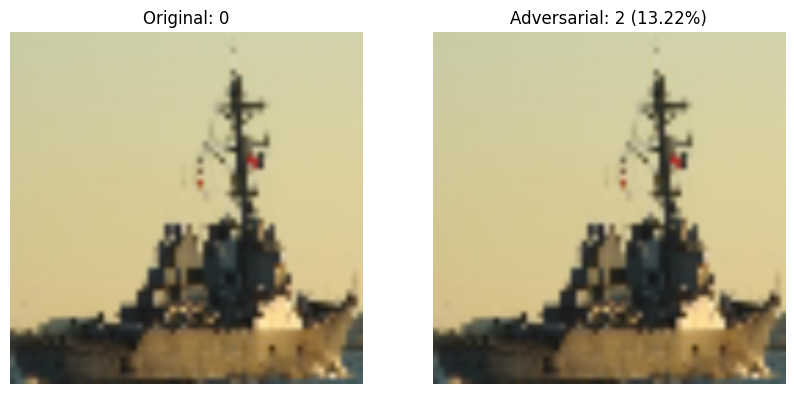

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


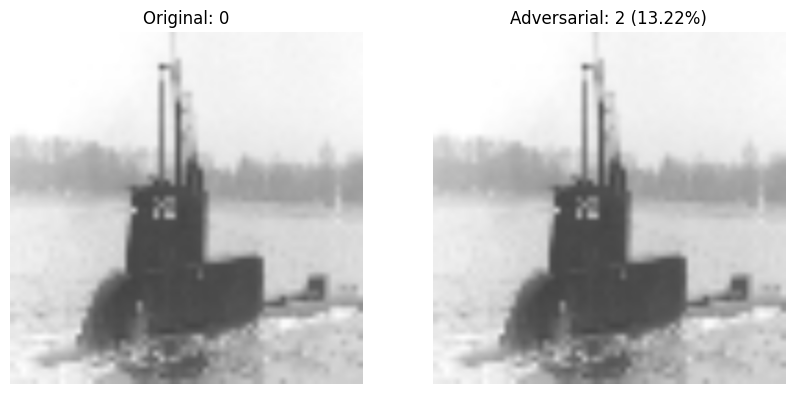

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


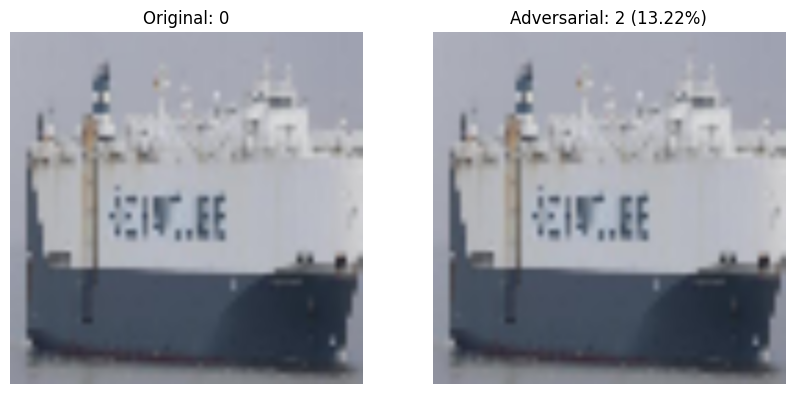

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


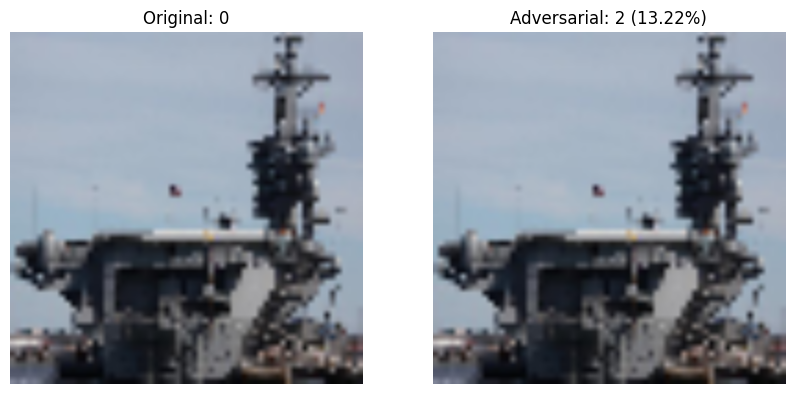

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


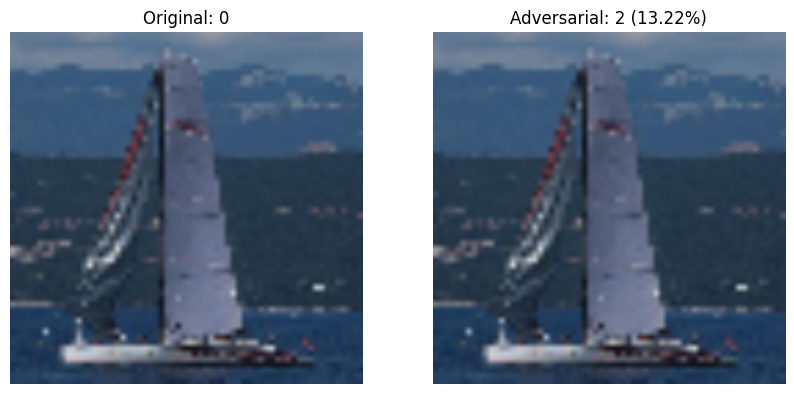

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


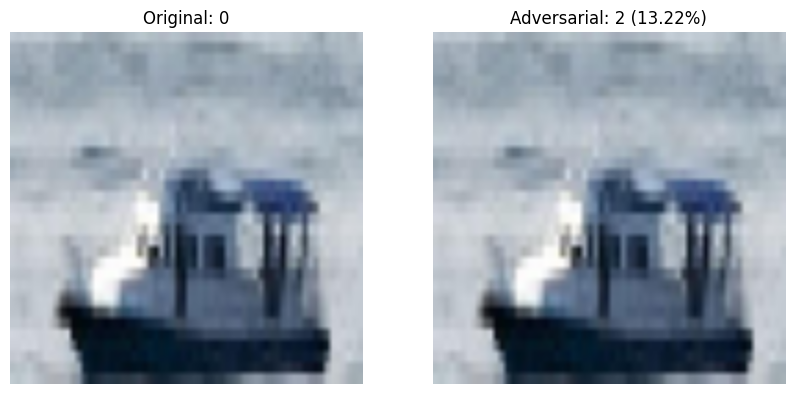

In [18]:
if __name__ == '__main__':
    # Load data
    test_images, test_labels = load_data('/kaggle/input/ships-dataset/Ships dataset/test/images', '/kaggle/input/ships-dataset/Ships dataset/test/labels')
    
    # Load the pre-trained model
    model = models.load_model('ShipClassifierV1.h5')
    
    # Perform adversarial training
    adversarial_training(model, test_images, test_labels, eps=0.1, epochs=10, batch_size=128)
    
    # Test and visualize non-targeted FGSM
    test_and_visualize(model, test_images, test_labels, eps=0.1)
    
    # Test and visualize targeted FGSM
    target_class = 1  # Example target class for targeted attack
    test_and_visualize(model, test_images, test_labels, eps=0.1, target_class=target_class)